In [7]:
pip install --upgrade ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [10]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [12]:
df = yf.download("AAPL", start="2020-01-01", end="2023-01-01", interval="1d")

prices = df['Close'].values

print("Number of data points:", len(prices))
print("Sample prices:", prices[:5])


[*********************100%***********************]  1 of 1 completed

Number of data points: 756
Sample prices: [[75.08750153]
 [74.35749817]
 [74.94999695]
 [74.59750366]
 [75.79750061]]


In [13]:
train_size = int(len(prices) * 0.7)
val_size   = int(len(prices) * 0.2)
test_size  = len(prices) - train_size - val_size

train_data = prices[:train_size]
val_data   = prices[train_size:train_size+val_size]
test_data  = prices[train_size+val_size:]


In [26]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=20):
        self.data = data
        self.lookback = lookback
        self.size = len(data) - lookback
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        x = self.data[idx : idx + self.lookback]  # shape (lookback,)
        y = self.data[idx + self.lookback]        # single value
        x = torch.tensor(x, dtype=torch.float32)  # => shape [lookback]
        y = torch.tensor(y, dtype=torch.float32)
        return x, y


In [32]:
class LSTMTimeSeriesModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=1):
        super(LSTMTimeSeriesModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # input_dim = 1 for univariate time series
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
         # x: [batch_size, seq_len, 1]
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)





In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMTimeSeriesModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x is [batch_size, seq_len]
        # Convert to [batch_size, seq_len, input_dim]
        x = x.unsqueeze(-1)
        out, (hn, cn) = self.lstm(x)           # => out: [batch_size, seq_len, hidden_dim]
        out = self.fc(out[:, -1, :])           # => [batch_size, 1]
        return out.squeeze(-1)                 # => [batch_size]

# Example training loop
hidden_dim = 32
num_layers = 1
learning_rate = 1e-3
epochs = 20

model = LSTMTimeSeriesModel(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    running_train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        # Check shape
        # print("x_batch shape:", x_batch.shape)
        
        optimizer.zero_grad()
        outputs = model(x_batch)              # => [batch_size]
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * x_batch.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            running_val_loss += val_loss.item() * x_val.size(0)
    
    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch}/{epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


RuntimeError: input must have 3 dimensions, got 5

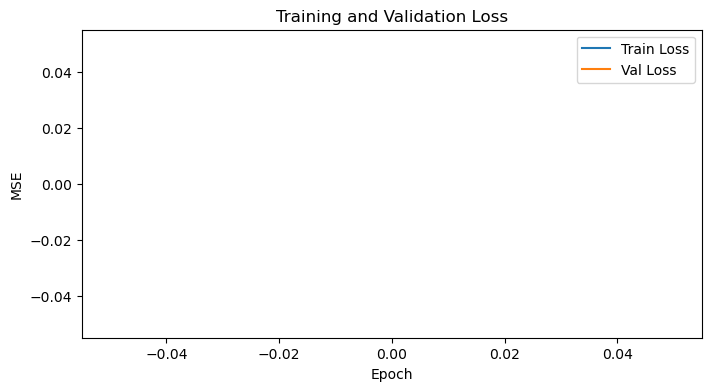

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [18]:
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        y_pred = model(x_test)
        preds.append(y_pred.detach().numpy())
        actuals.append(y_test.detach().numpy())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

# Plot predictions vs. actual
plt.figure(figsize=(8, 4))
plt.plot(actuals, label='Actual')
plt.plot(preds, label='Predicted')
plt.title('Test Data Predictions')
plt.xlabel('Time Step (sliding window index)')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors